In [1]:
import pandas as pd
import numpy as np
import gc
import lightgbm as lgb
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection, dummy, metrics
import pickle

print(pd.__version__) #1.1.3
print(np.__version__) #1.19.4
print(sns.__version__) #0.11.0
print(matplotlib.__version__) # 3.3.2
print(sklearn.__version__) # 0.23.2


1.1.3
1.19.4
0.11.0
3.3.2
0.23.2


# Récupération et préparation des données

In [2]:

X_train = pd.read_csv("data/X_train_resampled.csv")
y_train = pd.read_csv("data/y_train_resampled.csv")
X_test = pd.read_csv("data/X_test.csv")
y_test = pd.read_csv("data/y_test.csv")

cat_features = pickle.load(open("data/pickle_cat_features.pkl", "rb"))
cat_features_index = np.where(X_train.columns.isin(cat_features))

BETA = 2

In [3]:
X_train.drop(columns="Unnamed: 0", inplace=True)
X_test.drop(columns="SK_ID_CURR", inplace=True)
y_train.drop(columns="Unnamed: 0", inplace=True)
y_test.drop(columns="SK_ID_CURR", inplace=True)

print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test : {y_test.shape}")

def replace_name(name):
    for c in ["[","]",",","{","}",'"',":"," "]:
        if c in name :
            name = name.replace(c,"_")
    return name
            
features = list(map(replace_name, X_train.columns))
X_train.columns = features
X_test.columns = features

X_train : (310572, 676)
X_test : (61502, 676)
y_train : (310572, 1)
y_test : (61502, 1)


# Etablissement d'une baseline

In [4]:
%%time
# dummy classifier 
dummy_classifier = dummy.DummyClassifier(strategy="stratified", random_state=123)
dummy_classifier.fit(X_train,y_train)

CPU times: user 9.45 ms, sys: 3.63 ms, total: 13.1 ms
Wall time: 12.6 ms


DummyClassifier(random_state=123, strategy='stratified')

In [5]:
# performances
y_pred = dummy_classifier.predict_proba(X_test)[:, 1]
baseline = metrics.fbeta_score(y_test, y_pred, beta=BETA)
print(f"Baseline F_beta par dummy classifier  : {baseline}")

del dummy_classifier
gc.collect()

Baseline F_beta par dummy classifier  : 0.24743841290603882


0

# Entraînement d'un classifieur LightGBM sur le train set sur 5 folds (5 classifieurs)

In [6]:
# métrique F_beta

def f_beta(y_true, probas_pred):
    y_pred = np.vectorize(lambda x : 0 if x<0.5 else 1)(probas_pred)
    score = metrics.fbeta_score(y_true, y_pred, beta=BETA)
    return "F_beta", score, True

In [7]:
%%time
# modèle de cross validation pour entraînement par fold
folds = model_selection.StratifiedKFold(n_splits= 5, shuffle=True, random_state=123)

# création des dataframes pour stocker les résultats
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
feature_importance_df = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    # paramètres déterminés par optimisation Bayésienne
    clf = lgb.LGBMClassifier(
        n_jobs=-1,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=37,
        colsample_bytree=0.26424255740815,
        subsample=0.9222047021355166,
        max_depth=6,
        reg_alpha=0.8495823622837118,
        reg_lambda=0.7247308695357746,
        min_split_gain=0.05365093112258974,
        min_child_weight=28.91981182288273,
        silent=-1,
        verbose=-1,
        random_state=123,
        categorical_feature=list(cat_features_index[0]))
    
    
    # entraînement de chaque fold
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        eval_metric=f_beta, verbose= 200, early_stopping_rounds= 200)

    # stockage des prédictions
    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    # stockage des features importances
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X_train.columns
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    _, score, _ = f_beta(valid_y, oof_preds[valid_idx])
    print('Fold %2d F_beta : %.6f' % (n_fold + 1, score))
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()


/home/samuel/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/samuel/.local/lib/python3.8/site-packages/lightgbm/basic.py:1075: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'


Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.250345	training's F_beta: 0.897882	valid_1's binary_logloss: 0.252866	valid_1's F_beta: 0.897193
[400]	training's binary_logloss: 0.190042	training's F_beta: 0.904709	valid_1's binary_logloss: 0.195206	valid_1's F_beta: 0.903059
[600]	training's binary_logloss: 0.171369	training's F_beta: 0.909041	valid_1's binary_logloss: 0.179858	valid_1's F_beta: 0.90618
[800]	training's binary_logloss: 0.161139	training's F_beta: 0.911831	valid_1's binary_logloss: 0.172946	valid_1's F_beta: 0.907518
[1000]	training's binary_logloss: 0.15404	training's F_beta: 0.914129	valid_1's binary_logloss: 0.169311	valid_1's F_beta: 0.908414
[1200]	training's binary_logloss: 0.148755	training's F_beta: 0.915975	valid_1's binary_logloss: 0.167307	valid_1's F_beta: 0.909088
[1400]	training's binary_logloss: 0.144075	training's F_beta: 0.917604	valid_1's binary_logloss: 0.165913	valid_1's F_beta: 0.909386
[1600]	traini

[800]	training's binary_logloss: 0.16158	training's F_beta: 0.911374	valid_1's binary_logloss: 0.171814	valid_1's F_beta: 0.9077
[1000]	training's binary_logloss: 0.154927	training's F_beta: 0.913717	valid_1's binary_logloss: 0.168608	valid_1's F_beta: 0.908733
[1200]	training's binary_logloss: 0.149337	training's F_beta: 0.91562	valid_1's binary_logloss: 0.16643	valid_1's F_beta: 0.90927
[1400]	training's binary_logloss: 0.1446	training's F_beta: 0.917576	valid_1's binary_logloss: 0.165049	valid_1's F_beta: 0.909816
[1600]	training's binary_logloss: 0.140405	training's F_beta: 0.91911	valid_1's binary_logloss: 0.16403	valid_1's F_beta: 0.909747
Early stopping, best iteration is:
[1469]	training's binary_logloss: 0.14312	training's F_beta: 0.918071	valid_1's binary_logloss: 0.164646	valid_1's F_beta: 0.909923
Fold  5 F_beta : 0.909923
CPU times: user 3h 51min 9s, sys: 52.3 s, total: 3h 52min 1s
Wall time: 37min 40s


In [8]:
# affichage des performances

_, train_score, _ = f_beta(y_train, oof_preds)
_, test_score, _ = f_beta(y_test, sub_preds)
print(f"F_beta sur train set  : {train_score}")
print(f"F_beta sur test set : {test_score}")

F_beta sur train set  : 0.910831793266904
F_beta sur test set : 0.19608288648550395


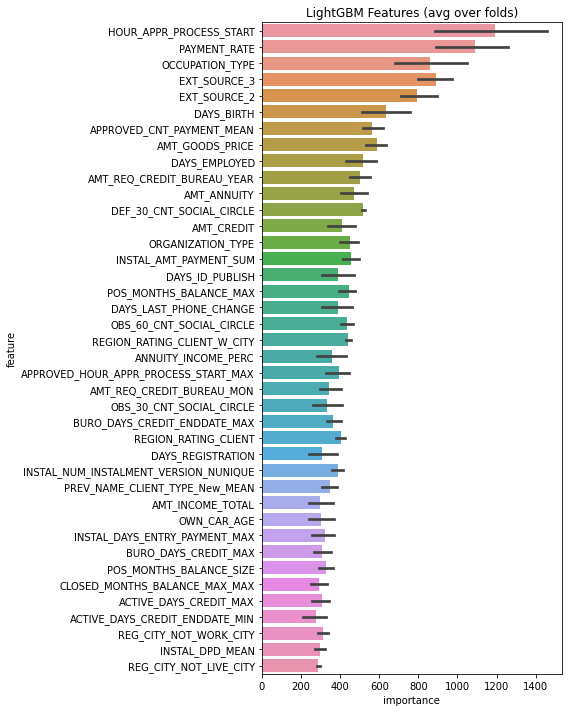

In [9]:
# affichage de l'importance des features

cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean()\
                    .sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('img/lgbm_importances01.png')

# Entraînement d'un LGBM Classifier unique sur le train set

In [10]:
# création d'un set de validation

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X_train, y_train, test_size=0.2, 
                                                                      random_state=123)

In [11]:
%%time
# modèle avec les mêmes paramètres

clf = lgb.LGBMClassifier(
        n_jobs=-1,
        n_estimators=10000,        
        learning_rate=0.02,
        num_leaves=37,
        colsample_bytree=0.26424255740815,
        subsample=0.9222047021355166,
        max_depth=6,
        reg_alpha=0.8495823622837118,
        reg_lambda=0.7247308695357746,
        min_split_gain=0.05365093112258974,
        min_child_weight=28.91981182288273,
        silent=-1,
        verbose=-1,
        random_state=123,
        categorical_feature=list(cat_features_index[0]))

# entraînement
clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
    eval_metric=f_beta, verbose= 200, early_stopping_rounds= 200)

/home/samuel/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/samuel/.local/lib/python3.8/site-packages/lightgbm/basic.py:1075: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'


Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.249977	training's F_beta: 0.897788	valid_1's binary_logloss: 0.253609	valid_1's F_beta: 0.895432
[400]	training's binary_logloss: 0.190442	training's F_beta: 0.904732	valid_1's binary_logloss: 0.197124	valid_1's F_beta: 0.902126
[600]	training's binary_logloss: 0.171002	training's F_beta: 0.908876	valid_1's binary_logloss: 0.181107	valid_1's F_beta: 0.905388
[800]	training's binary_logloss: 0.161077	training's F_beta: 0.911873	valid_1's binary_logloss: 0.174614	valid_1's F_beta: 0.907267
[1000]	training's binary_logloss: 0.154007	training's F_beta: 0.913928	valid_1's binary_logloss: 0.170839	valid_1's F_beta: 0.908283
[1200]	training's binary_logloss: 0.148492	training's F_beta: 0.916003	valid_1's binary_logloss: 0.168705	valid_1's F_beta: 0.908821
[1400]	training's binary_logloss: 0.143626	training's F_beta: 0.917855	valid_1's binary_logloss: 0.167142	valid_1's F_beta: 0.909649
[1600]	trai

LGBMClassifier(categorical_feature=[1, 2, 3, 4, 10, 11, 12, 13, 14, 21, 22, 23,
                                    24, 25, 26, 27, 31, 39, 85, 86, 88, 89, 95,
                                    96, 97, 98, 99, 100, 101, 102, ...],
               colsample_bytree=0.26424255740815, learning_rate=0.02,
               max_depth=6, min_child_weight=28.91981182288273,
               min_split_gain=0.05365093112258974, n_estimators=10000,
               num_leaves=37, random_state=123, reg_alpha=0.8495823622837118,
               reg_lambda=0.7247308695357746, silent=-1,
               subsample=0.9222047021355166, verbose=-1)

In [12]:
# performances

y_pred = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1]
f_beta(y_test, y_pred)

('F_beta', 0.19889201707383522, True)

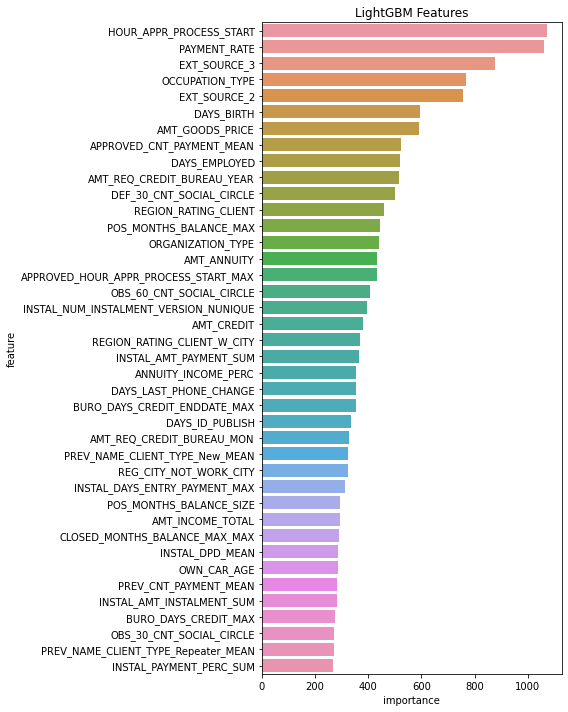

In [13]:
# features importances

feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns
feature_importance_df["importance"] = clf.feature_importances_
best_features_idx = feature_importance_df.sort_values(by="importance", ascending=False)[:40].index
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=feature_importance_df.iloc[best_features_idx].sort_values(by="importance", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()

Les performances sont à peine moins bonnes, je garde donc ce principe d'un classifieur unique.


In [14]:
# AUROC du modèle

print(metrics.roc_auc_score(y_test, y_pred))


0.7783272256112571


Seuil 0.1 f-beta-score 0.4350774748264288
Seuil 0.11 f-beta-score 0.43843440282210644
Seuil 0.12000000000000001 f-beta-score 0.44279153354632583
Seuil 0.13 f-beta-score 0.4447059432059174
Seuil 0.14 f-beta-score 0.44261286092750685
Seuil 0.15000000000000002 f-beta-score 0.4401116515587
Seuil 0.16 f-beta-score 0.437937510670992
Seuil 0.17 f-beta-score 0.43268527992983485
Seuil 0.18 f-beta-score 0.427219468228932
Seuil 0.19 f-beta-score 0.4228303747534517
Seuil 0.2 f-beta-score 0.4212303904548467
Seuil 0.21000000000000002 f-beta-score 0.41595377215353324
Seuil 0.22 f-beta-score 0.4108798205390426
Seuil 0.23 f-beta-score 0.4064972226897829
Seuil 0.24000000000000002 f-beta-score 0.4005212262533434
Seuil 0.25 f-beta-score 0.3933682373472949


Text(0, 0.5, 'F-beta-score')

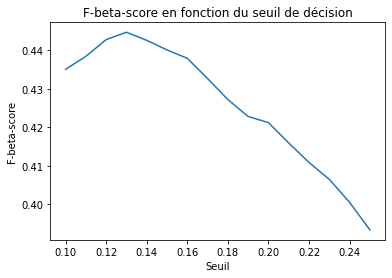

In [15]:
# recherche du seuil optimisant le f_beta

scores = list()
thresolds = np.linspace(0.1, 0.25, 16)

for thres in np.linspace(0.1, 0.25, 16):
    y_pred_label = [0 if i<=thres else 1 for i in y_pred]
    score = metrics.fbeta_score(y_test, y_pred_label, beta=BETA)
    scores.append(score)
    print(f"Seuil {thres} f-beta-score {score}")
    
sns.lineplot(x=thresolds, y=scores)
plt.title("F-beta-score en fonction du seuil de décision")
plt.xlabel("Seuil")
plt.ylabel("F-beta-score")

              precision    recall  f1-score   support

         0.0     0.9548    0.8252    0.8853     56547
         1.0     0.2173    0.5538    0.3121      4955

    accuracy                         0.8033     61502
   macro avg     0.5860    0.6895    0.5987     61502
weighted avg     0.8953    0.8033    0.8391     61502

[[46663  9884]
 [ 2211  2744]]


<AxesSubplot:>

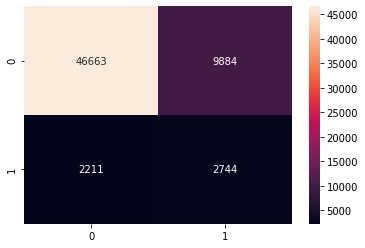

In [16]:
# rapport de performances 

thres = 0.19
y_pred_label = [0 if i<=thres else 1 for i in y_pred]
print(metrics.classification_report(y_test, y_pred_label, digits=4))
conf_matrix = metrics.confusion_matrix(y_test, y_pred_label)
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt="d")
